In [2]:
import pickle
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import sys; sys.path.append("../../..")  # Allows access to all the scripts/modules in the larger directory
from utils import calc_loadings
from sklearn.metrics import hamming_loss, accuracy_score
from collections import defaultdict
from scipy.linalg import subspace_angles

### Load consolidated decoding dataframe

In [3]:
decoding_glom_path = '/home/marcush/Data/TsaoLabData/neural_control_output/decoding_clear_final_analysis_230809_140453_Alfie/decoding_clear_final_analysis_230809_140453_Alfie_glom.pickle'
with open(decoding_glom_path, 'rb') as f:
    dat_decode = pickle.load(f) 

df_decode = pd.DataFrame(dat_decode)

In [4]:
# Helpful ways to index / look at the df_decode
filtered_df_decode = df_decode[(df_decode['loader_args'].apply(lambda x: x.get('region')) == 'AM') & (df_decode['dimreduc_method'] == 'PCA') ]
df_decode.columns

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'dimreduc_method',
       'dimreduc_args', 'coef', 'score', 'full_arg_tuple', 'predictions',
       'loss', 'decoding_object', 'Xtrain', 'Xtest', 'Ytrain', 'Ytest',
       'decoder', 'decoder_args', 'thresholds', 'data_file', 'loader',
       'loader_args', 'task_args', 'data_path', 'results_file'],
      dtype='object')

In [5]:
data_path = df_decode['data_path']

#### Load the processed data as well for other info

In [6]:
def make_hashable(obj):
    if isinstance(obj, dict):
        return tuple(sorted((key, make_hashable(value)) for key, value in obj.items()))
    elif isinstance(obj, (list, tuple)):
        return tuple(make_hashable(item) for item in obj)
    else:
        return obj


unique_hashes = set(make_hashable(d) for d in df_decode['full_arg_tuple'])
unique_dicts = [dict(u) for u in unique_hashes]

In [7]:
preload_dict_path = df_decode['data_path'][0] + "/preloaded/preloadDict.pickle"

with open(preload_dict_path, 'rb') as file:
    preloadDict = pickle.load(file)


for arg_dict in unique_dicts:
    arg_tuple = tuple(sorted(arg_dict.items()))


    for args in preloadDict.keys():

        if args == arg_tuple:

            preloadID = preloadDict[arg_tuple]
            loaded_data_path = os.path.dirname(preload_dict_path) + f"/preloaded_data_{preloadID}.pickle"
            
            if arg_dict['region'] == 'AM':
                with open(loaded_data_path, 'rb') as file:
                    AM_loaded_data = pickle.load(file)

            elif arg_dict['region'] == 'ML':
                with open(loaded_data_path, 'rb') as file:
                    ML_loaded_data = pickle.load(file)

AM_spikes = np.sum(AM_loaded_data['spike_rates'], 1)
ML_spikes = np.sum(ML_loaded_data['spike_rates'], 1)

In [8]:
AM_spikes.shape, ML_spikes.shape

((4304, 168), (4304, 374))

In [36]:
AM_loaded_data['StimulusNames']

['clear_train_00002.png',
 'clear_train_00012.png',
 'clear_train_00019.png',
 'clear_train_00042.png',
 'clear_train_00048.png',
 'clear_train_00050.png',
 'clear_train_00051.png',
 'clear_train_00055.png',
 'clear_train_00057.png',
 'clear_train_00059.png',
 'clear_train_00061.png',
 'clear_train_00067.png',
 'clear_train_00071.png',
 'clear_train_00075.png',
 'clear_train_00085.png',
 'clear_train_00092.png',
 'clear_train_00094.png',
 'clear_train_00096.png',
 'clear_train_00100.png',
 'clear_train_00101.png',
 'clear_train_00107.png',
 'clear_train_00110.png',
 'clear_train_00118.png',
 'clear_train_00120.png',
 'clear_train_00121.png',
 'clear_train_00123.png',
 'clear_train_00124.png',
 'clear_train_00125.png',
 'clear_train_00126.png',
 'clear_train_00129.png',
 'clear_train_00131.png',
 'clear_train_00132.png',
 'clear_train_00135.png',
 'clear_train_00138.png',
 'clear_train_00143.png',
 'clear_train_00144.png',
 'clear_train_00148.png',
 'clear_train_00152.png',
 'clear_trai

(array([   8.,    0.,    0., 1102.,    0.,    0., 2904.,    0.,    0.,
         290.]),
 array([134., 139., 144., 149., 154., 159., 164., 169., 174., 179., 184.]),
 <BarContainer object of 10 artists>)

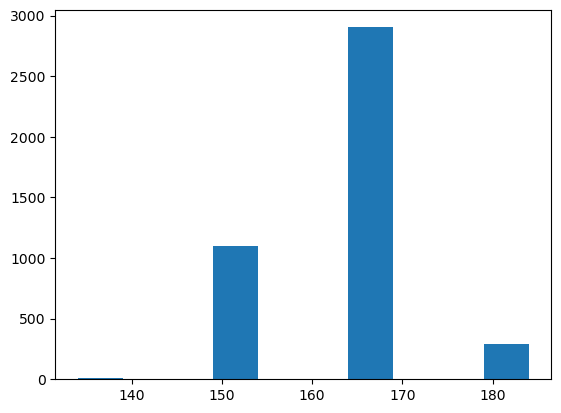

In [33]:
plt.hist(AM_loaded_data['StimulusOnDurations'])

Text(0.5, 1.0, 'Number of times clear face stimuli were shown.')

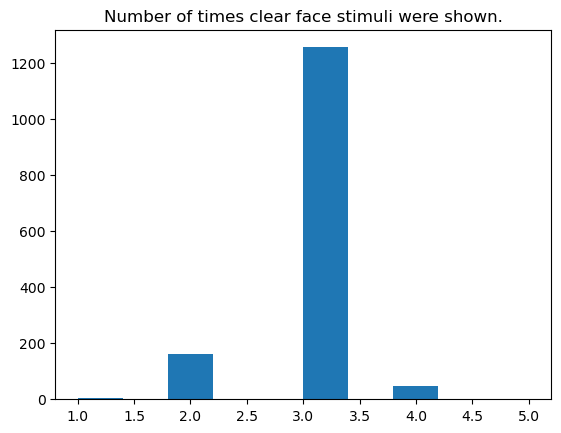

In [35]:
unique_elements, counts = np.unique(AM_loaded_data["StimIDs"], return_counts=True)
plt.hist(counts)
plt.title("Number of times clear face stimuli were shown.")

### Extract useful params and get average classification error 

In [10]:
degradedIDs = AM_loaded_data['degradedIDs']
dimensions = np.unique(df_decode['dim'])
n_folds = np.unique(df_decode['fold_idx'])
regions = np.unique(df_decode['loader_args'].apply(lambda x: x.get('region')))
dimreduc_methods = np.unique(df_decode['dimreduc_method'])
stimIDs = AM_loaded_data['StimIDs']

In [11]:
def recursive_defaultdict():
    return defaultdict(recursive_defaultdict)
all_losses = recursive_defaultdict()
 
for dr_method in dimreduc_methods:
    for reg in regions:
        all_losses[dr_method][reg] = np.zeros(len(dimensions))
        for idx, dim in enumerate(dimensions):

            df_decode_filt = df_decode[(df_decode['loader_args'].apply(lambda x: x.get('region')) == reg) & (df_decode['dimreduc_method'] == dr_method) & (df_decode['dim'] == dim)]
            avg_loss = np.mean(df_decode_filt['loss']) # averages loss over k_fold splits
            all_losses[dr_method][reg][idx] = avg_loss

## Average classification accuracy in subspaces

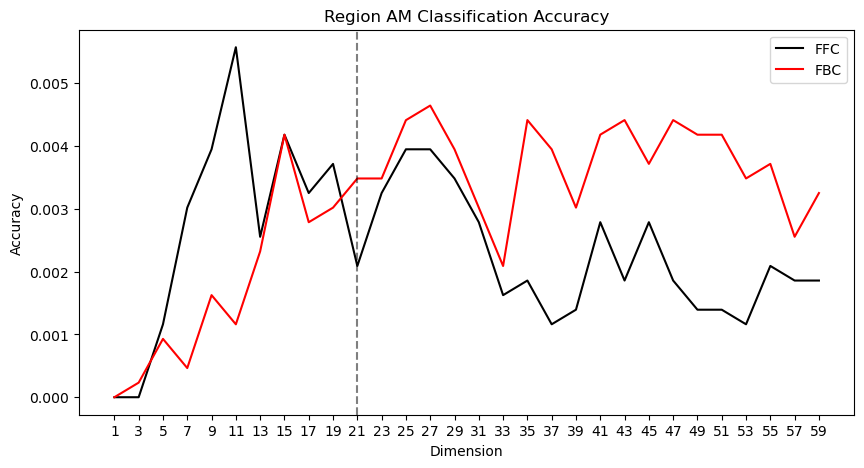

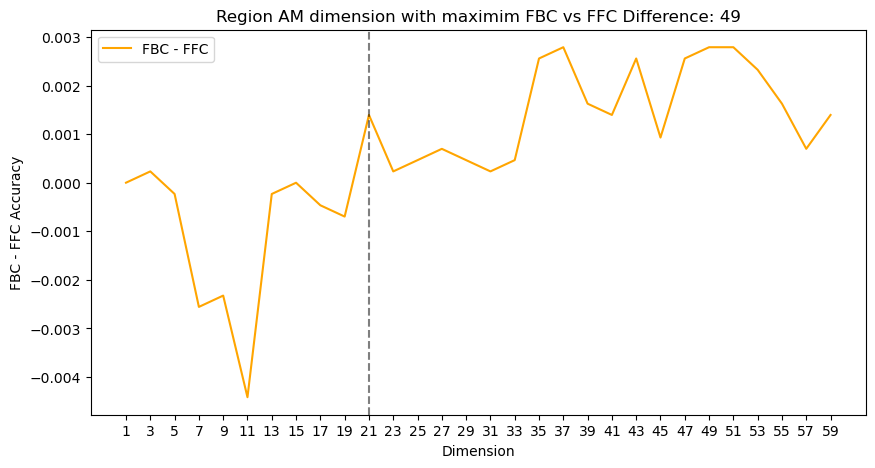

Max fold difference: 2.9996125532740745


In [12]:
region = 'AM'

FFC_losses = 1 - all_losses['PCA'][region]
FBC_losses = 1 - all_losses['LQGCA'][region]
Diff_losses = FBC_losses - FFC_losses
max_dim_ind = np.argmax(Diff_losses)
max_diff_dim = dimensions[max_dim_ind]


plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, FFC_losses, label="FFC", color='black')
plt.plot(dimensions, FBC_losses, label="FBC", color='red')

plt.legend()
plt.title(f'Region {region} Classification Accuracy')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
#plt.axvline(x=max_diff_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.axvline(x=21, color=[0, 0, 0, 0.5], linestyle='--') 
plt.show()

"""" 
plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, [np.sum(FFC_losses[0:idx]) for idx, loss in enumerate(FFC_losses) ], label="FFC")
plt.plot(dimensions, [np.sum(FBC_losses[0:idx]) for idx, loss in enumerate(FBC_losses) ], label="FBC")

plt.legend()
plt.title(f'Region {region} Classification Accuracy')
plt.xticks(dimensions[0:-2])
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.show()

"""

plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, Diff_losses, label="FBC - FFC", color='orange')

plt.legend()
plt.title(f'Region {region} dimension with maximim FBC vs FFC Difference: {max_diff_dim}')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('FBC - FFC Accuracy')
#plt.axvline(x=max_diff_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.axvline(x=21, color=[0, 0, 0, 0.5], linestyle='--') 
plt.show()

print(f"Max fold difference: {FBC_losses[max_dim_ind]/FFC_losses[max_dim_ind]}")



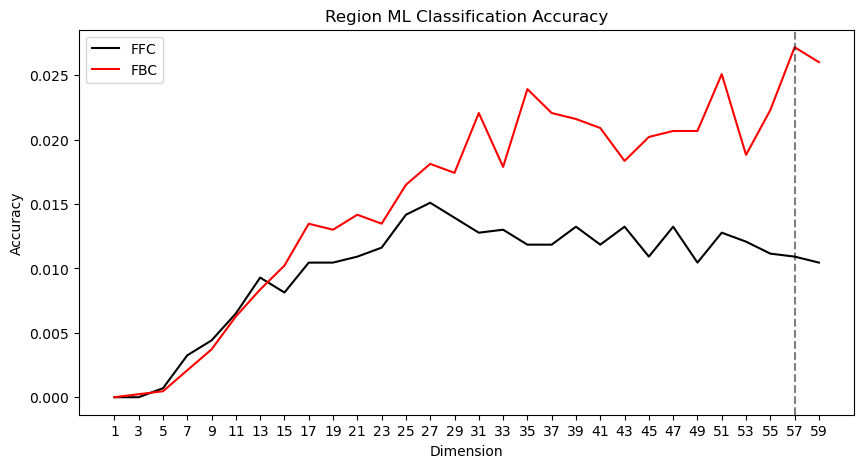

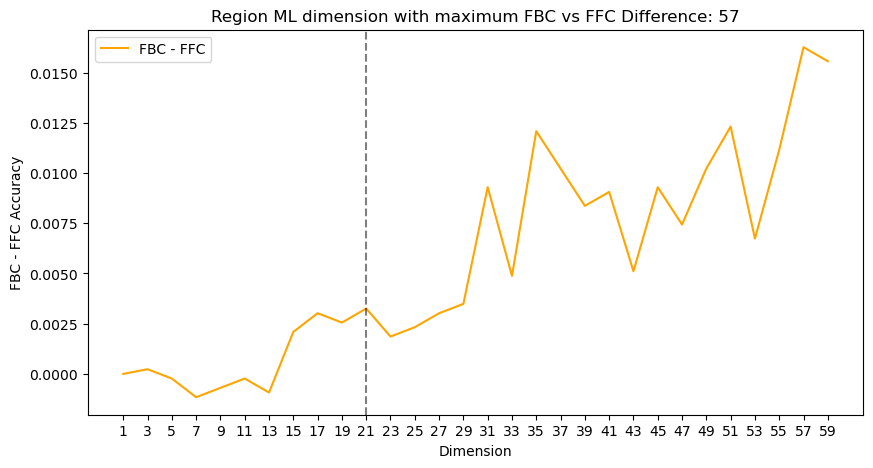

Max fold difference: 2.489203828745279


In [13]:
region = 'ML'

FFC_losses = 1 - all_losses['PCA'][region]
FBC_losses = 1 - all_losses['LQGCA'][region]
Diff_losses = FBC_losses - FFC_losses
max_dim_ind = np.argmax(Diff_losses)
max_diff_dim = dimensions[max_dim_ind]


plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, FFC_losses, label="FFC", color='black')
plt.plot(dimensions, FBC_losses, label="FBC", color='red')

plt.legend()
plt.title(f'Region {region} Classification Accuracy')
plt.xticks(dimensions)
plt.axvline(x=max_diff_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.show()


plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, Diff_losses, label="FBC - FFC", color='orange')

plt.legend()
plt.title(f'Region {region} dimension with maximum FBC vs FFC Difference: {max_diff_dim}')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('FBC - FFC Accuracy')
#plt.axvline(x=max_diff_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.axvline(x=21, color=[0, 0, 0, 0.5], linestyle='--') 
plt.show()


print(f"Max fold difference: {FBC_losses[max_dim_ind]/FFC_losses[max_dim_ind]}")


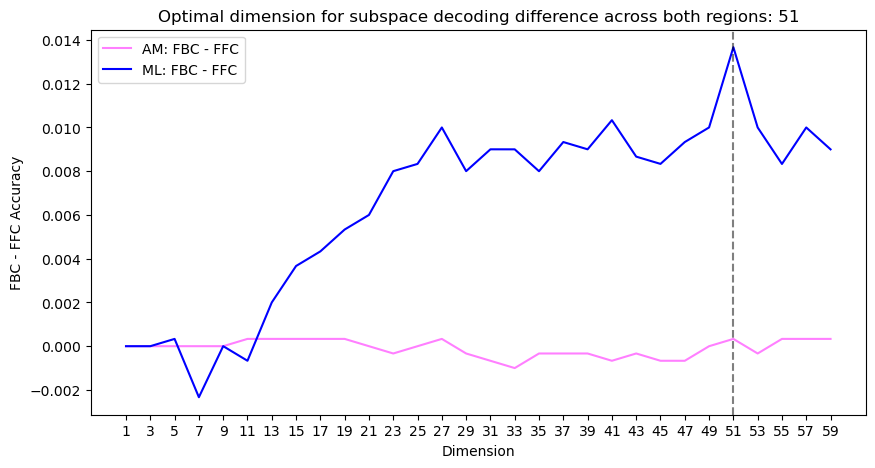

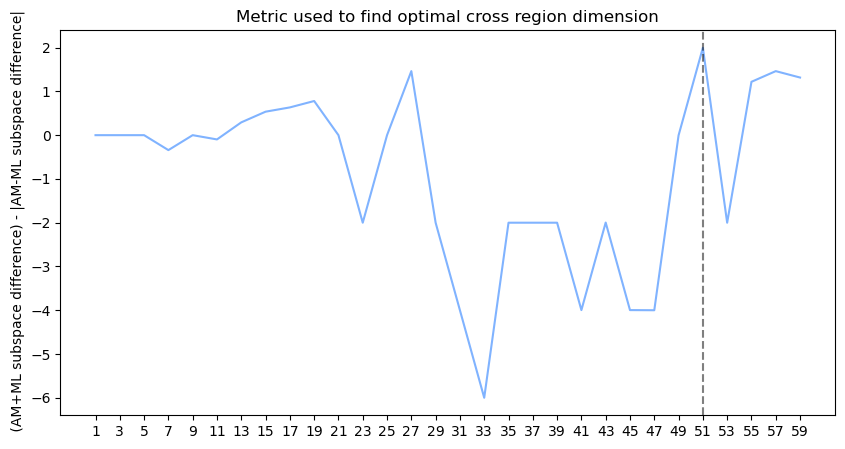

ML max diff percent : 1.0, AM max diff percent: 0.9983361064890278


In [15]:
plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall

region = 'AM'
FFC_losses = 1 - all_losses['PCA'][region]
FBC_losses = 1 - all_losses['LQGCA'][region]
AM_diff_losses = FBC_losses - FFC_losses
max_dim_ind = np.argmax(AM_diff_losses)
max_diff_dim = dimensions[max_dim_ind]
plt.plot(dimensions, AM_diff_losses,label=f"{region}: FBC - FFC", color=[1, 0, 1, 0.5])

region = 'ML'
FFC_losses = 1 - all_losses['PCA'][region]
FBC_losses = 1 - all_losses['LQGCA'][region]
ML_diff_losses = FBC_losses - FFC_losses
max_dim_ind = np.argmax(ML_diff_losses)
max_diff_dim = dimensions[max_dim_ind]
plt.plot(dimensions, ML_diff_losses, color='b', label=f"{region}: FBC - FFC")

"""
Computing the optimal dimension across regions:

    1. For both regions, across all dimensions, find the difference in decoding in FBC and FFC subspaces (specifically, FBC-FFC)
    2. Normalize each area's decoding difference by the maximum decoding difference (this way both regions decoding difference is on the same scale)
    3. Sum across both regions to find dimensions with highest (fraction of each region's total) FBC-FFC decoding difference
    4. Subtract by the per-dimension difference between each region's percent of maximal decoding difference
    5. Find dimension which optimizes this.

"""
ML_perc_max = ML_diff_losses / np.max(ML_diff_losses)
AM_perc_max = AM_diff_losses / np.max(AM_diff_losses)

combined_perc_max = ML_perc_max+AM_perc_max
metric = combined_perc_max - np.abs(ML_perc_max-AM_perc_max)
opt_dim_ind = np.argmax(metric)
opt_dim = dimensions[opt_dim_ind]


plt.legend()
plt.title(f'Optimal dimension for subspace decoding difference across both regions: {opt_dim}')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('FBC - FFC Accuracy')
#plt.axvline(x=max_diff_dim, color='r', linestyle='--') 
plt.axvline(x=opt_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.show()



plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, metric, label="ML: FBC - FFC", color=[0.5, 0.7, 1, 1])
plt.axvline(x=opt_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.xticks(dimensions)
plt.title(f'Metric used to find optimal cross region dimension')
plt.ylabel(' (AM+ML subspace difference) - |AM-ML subspace difference|')
plt.show()

print(f"ML max diff percent : {ML_perc_max[opt_dim_ind]}, AM max diff percent: {AM_perc_max[opt_dim_ind]}")

#print(" ")
#for idx, dim in enumerate(dimensions):
#    print(f"Dim: {dim}, ML max diff percent : {np.round(ML_perc_max[idx]*100, 3)}, AM max diff percent: {np.round(AM_perc_max[idx]*100, 3)}")


